In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 15, 25

import torch
import torch.nn as nn
import torch.utils.data.dataloader as dataloader

import torchvision
from torchvision import transforms, datasets

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

In [2]:
#Torchvision
transformations={
    "train":transforms.Compose(
    [transforms.RandomRotation(10),#Rotation aléatoire de -10° à 10°
     transforms.RandomHorizontalFlip(),#Inverse l'image horizontalement
     transforms.ColorJitter(hue=.05, saturation=.05),#Legere modification/Saturation de l'image.
     transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "test": transforms.Compose([
        transforms.Resize([224,224]),#Resize en 224 par 224
        transforms.ToTensor(),#Tranforme en torch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#Normalisation selon les standards imageNet
    ])
}

In [3]:
trainset = datasets.ImageFolder(root="./data/CatVSDog/subsample_2000_Ntrain_800_Nval/train/", transform=transformations["train"])
trainloader = dataloader.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)
testset = datasets.ImageFolder(root="./data/CatVSDog/subsample_2000_Ntrain_800_Nval/validation/", transform=transformations["test"])
testloader = dataloader.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

classes = ('cat', 'dog')

In [4]:
# Defining Model as Resnet50 pretrained and extracted from Models of torchvision
import torchvision.models as models
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
for params in model.parameters():
    params.requires_grad = False

classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

model.fc = classifier

In [6]:
import torch.optim as optim
# Defining Loss criterion and Optimiser
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Moves the model to either CPU or GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
from functions.training import train_model, evaluate_model

losses = []
accuracies = []
EPOCHS = 1
batch_size = 256
nb_batch = int(np.ceil(len(trainloader.dataset)/batch_size))

for epoch in range(EPOCHS):
    losses.extend(train_model(trainloader, device, model, optimizer, epoch, EPOCHS, batch_size)[-nb_batch:])
    accuracies.append(evaluate_model(model, device, testloader, losses[-1], EPOCHS, epoch, batch_size, len(trainloader.dataset)))

 Train Epoch: 1/1 [2000/2000 (100%)]	Loss: 0.081471	 Test Accuracy: 63.6250%


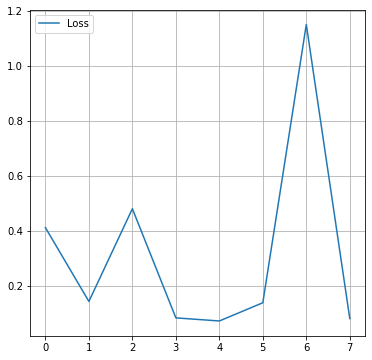

In [8]:
mpl.rcParams['figure.figsize'] = 6,6
plt.plot(losses, label='Loss')
plt.legend()
plt.grid()
plt.show()

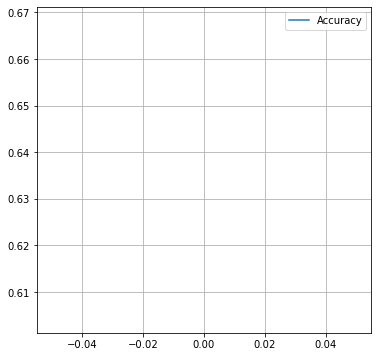

In [9]:
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.grid()
plt.show()

In [11]:
PATH = './resnet50_catsvsdogs.pth'
torch.save(model.state_dict(), PATH)

# Tests

In [ ]:
traininglosses =[]
testinglosses= []
testaccuracy= []
totalsteps= []

epochs = 1
steps = 0
runn = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        
        optimizer.step()
        
        runn += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            acc = 0
            
            for images, labels in testloader:
                
                images, labels= images.to(device), labels.to(device)
                
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_ps, top_c = ps.topk(1, dim=1)
                equal = top_c == labels.view(top_c.shape)
                acc += torch.mean(equal.type(torch.FloatTensor)).item()
                
            traininglosses.append(runn/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(acc/len(testloader))
            totalsteps.append(steps)    
                
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {runn/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {acc/len(testloader):.3f}")
            runn = 0
            model.train()

Epoch 1/1.. Train loss: 0.321.. Test loss: 0.451.. Test accuracy: 0.765
Epoch 1/1.. Train loss: 0.319.. Test loss: 0.328.. Test accuracy: 0.844
Epoch 1/1.. Train loss: 0.448.. Test loss: 0.827.. Test accuracy: 0.672


In [ ]:
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()